In [185]:
from selenium import webdriver
import time
import re
import datetime
import os
from bs4 import BeautifulSoup
import numpy as np
import itp_creds
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
geckoDriverPath = '/Users/matthewmitchell/Documents/Projects/Tools/Python/Scraping/geckodriver'

In [150]:
driver = webdriver.Firefox(executable_path=geckoDriverPath)
driver.get("https://itp.nyu.edu/camp2023/people")

## Proceed to Login / Navigate Back to People Page

In [97]:
def sim_type(string, element):
    for i in string:
        element.send_keys(i)
        pause = np.random.uniform(0,0.1)
        time.sleep(pause)

In [ ]:
email_input = driver.find_element_by_id("signin_email")
sim_type(itp_creds.u, email_input)

In [152]:
password_input = driver.find_element_by_id("signin_password")
sim_type(itp_creds.p, password_input)

In [153]:
signin_button = driver.find_element_by_xpath('//button[text()="Sign In"]')

In [154]:
signin_button.click()

In [155]:
driver.get("https://itp.nyu.edu/camp2023/people")

In [156]:
cur_html = driver.page_source

In [157]:
cur_url = driver.current_url

In [149]:
#Close the Browser
driver.close()

## Save Current HTML to Disk

In [38]:
## Create Filename:
def sub_all(pattern, sub_str, start_str):
    update = re.sub(pattern, sub_str, start_str)
    if update != start_str:
        #recurse!
        return sub_all(pattern, sub_str, update)
    else:
        return update

cleaned_url = sub_all("[:/.]","-", cur_url.strip("https://"))
print("Finalized updated:")
print(cleaned_url)

Finalized updated:
itp-nyu-edu-camp2023-people


In [ ]:
root_dir = os.getcwd()

In [76]:
def snapshot_page_html(html, url):
    #Clean URL For SubFolder Creation
    cleaned_url = sub_all("[:/.]","-", cur_url.strip("https://"))
    
    #Get CWD
    root_dir = os.getcwd()
    
    #Create SubFolder (if Necessary)
    os.chdir(root_dir)
    if os.path.isdir(cleaned_url):
        os.chdir(cleaned_url)
    else:
        os.mkdir(cleaned_url)
        os.chdir(cleaned_url)
        
    #Record Snapshot Time
    time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
    
    #Create Filename
    filename = "WebPageSnapshot_{}.html".format(time_now)
    
    #Write HTML to File
    if os.path.isfile(filename):
        print("File already exists.")
        os.chdir(root_dir)
        return None
    with open(filename, "w") as f:
        f.write(cur_html)
        
    #Return to Original Directory
    os.chdir(root_dir)

In [114]:
os.chdir(root_dir)

In [158]:
os.getcwd()

'/Users/matthewmitchell/Documents/ITP Camp'

In [159]:
os.listdir()

['Ex_Default_Project.1.toe',
 '7A7A5008.JPG',
 'Ex_Default_Project.toe',
 'Show One Thing Show 2023.pdf',
 '__pycache__',
 'itp-nyu-edu-camp2023-people',
 'geckodriver.log',
 '.ipynb_checkpoints',
 '7A7A5007.JPG',
 'ITP People Bio Scraper.ipynb',
 '7A7A4732.JPG',
 'itp_creds.py']

In [163]:
sorted(os.listdir('itp-nyu-edu-camp2023-people'))

['WebPageSnapshot_06-07-23_2244PM.html',
 'WebPageSnapshot_06-07-23_2245PM.html',
 'WebPageSnapshot_06-07-23_2246PM.html',
 'WebPageSnapshot_06-07-23_2247PM.html',
 'WebPageSnapshot_06-07-23_2305PM.html',
 'WebPageSnapshot_06-07-23_2321PM.html']

In [164]:
snapshot_page_html(cur_html, cur_url)

## Above Could Now Be Deployed on Regulard Crontab Job

## Sample Parse

In [119]:
soup = BeautifulSoup(cur_html)

In [167]:
people_divs = soup.find_all("div", {"class": "userListItem"})
print(len(people_divs))

people = []
for div in people_divs:
    profile_info = div.find_all("p", {"class":"profileInfo"})[0]
    name = profile_info.get_text().strip().split("   ")[0]
    shortAbout = profile_info.find("span", {"class":"shortAbout"})
    shortAbout = shortAbout.get_text()
    people.append((name, shortAbout))
people[:5]

258


[('Abby Schmiedt', ''),
 ('Ada Varriale (she/her)',
  'from italy, living in Amsterdam and doing a master in experimental publishing in Rotterdam(xpub.nl if...'),
 ('Addison Worthington', ''),
 ('Adeline Setiawan', ''),
 ('Adnan', '')]

In [169]:
df = pd.DataFrame(people)
print(len(df))
df.columns = ['Name','shortAbout']
df.head()

258


,Name,shortAbout
0,Abby Schmiedt,
1,Ada Varriale (she/her),"from italy, living in Amsterdam and doing a ma..."
2,Addison Worthington,
3,Adeline Setiawan,
4,Adnan,


## Filter Out Null Bios....

In [174]:
temp = df.shortAbout == ""
temp.value_counts()

True     172
False     86
Name: shortAbout, dtype: int64

In [175]:
corpus = list(df[df.shortAbout!=""].shortAbout)
print(len(corpus))
corpus[:5]

86


['from italy, living in Amsterdam and doing a master in experimental publishing in Rotterdam(xpub.nl if...',
 'Administrative Aide II',
 "I'm a professional editor and writer, semi-professional crafter, and deeply amateur game developer.",
 "Hi campers! I'm a lecturer at UMD College Park, where I do graduate classes on interaction design and...",
 "Hello! I'm a project manager, and budding creative technologist, at a retail tech lab (Brand Experience..."]

## TF-IDF on shortAbout Corpus
https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents

In [178]:
vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
tfidf = vect.fit_transform(corpus)                                                                                                                                                                                                                       
pairwise_similarity = tfidf * tfidf.T

In [181]:
pairwise_similarity.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Visualizing Pairwise Similarities

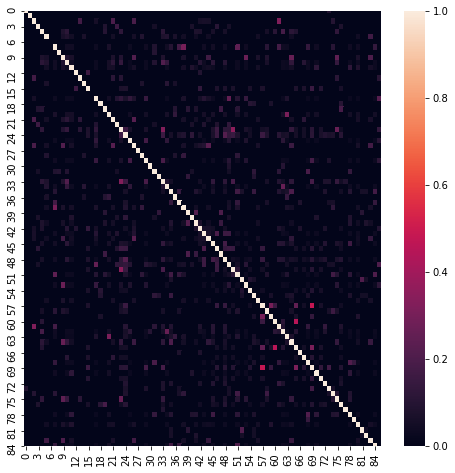

In [186]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(pairwise_similarity.toarray())

## Basic Clustering with KMeans

[Basic Tutorial from Kaggle](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans_)

## Network Visualization with TSNE

## Adding User Names to Cluster Diagram

## SlackBot Integration...